# Training a Model with TensorFlow on for Emotion Detection

Checking GPU availability and setting up TensorFlow for GPU usage.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2025-05-27 19:08:23.215634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 19:08:23.278922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 19:08:23.278954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 19:08:23.280249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 19:08:23.287531: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2025-05-27 19:08:49.763865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-27 19:08:49.836124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-27 19:08:49.836163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [51]:
# imports
import tensorflow as tf
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Loading the dataset
dataset = load_dataset("emotion", cache_dir="./cache")

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 212504.32 examples/s]


In [5]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", cache_dir="./cache")

/mnt/d/Github/Emotion_Detection_Text_Classification/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
# Separating the dataset into training, validation, and test sets
train_dataset = dataset["train"].map(tokenize_function, batched=True)
validation_dataset = dataset["validation"].map(tokenize_function, batched=True)
test_dataset = dataset["test"].map(tokenize_function, batched=True)

Map: 100%|██████████| 16000/16000 [00:00<00:00, 42699.71 examples/s]


In [27]:
# initializing a data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf", padding=True)

In [29]:
def create_tf_dataset(dataset, tokenizer, batch_size=32, shuffle=True):
    # Convert to TensorFlow dataset with dynamic padding
    tf_dataset = dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=data_collator,
        drop_remainder=False  # Keep all samples
    )
    return tf_dataset


In [30]:
# Creating tensorflow datasets
train_tf_dataset = create_tf_dataset(train_dataset, tokenizer, batch_size=32, shuffle= True)
validation_tf_dataset = create_tf_dataset(validation_dataset, tokenizer, batch_size=32, shuffle=False)
test_tf_dataset = create_tf_dataset(test_dataset, tokenizer, batch_size=32, shuffle=False)


/mnt/d/Github/Emotion_Detection_Text_Classification/venv/lib/python3.11/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [32]:
# Loading the model
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

/mnt/d/Github/Emotion_Detection_Text_Classification/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertF

In [ ]:
# Defining the model
history = model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

# Training the model
model.fit(
    train_tf_dataset,
    validation_data=validation_tf_dataset,
    epochs=3
)

Epoch 1/3


2025-05-27 21:06:46.963342: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9708750110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-27 21:06:46.963499: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-27 21:06:47.167431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-27 21:06:47.412058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1748360207.947984   14532 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 82s 121ms/step - loss: 0.5825 - accuracy: 0.7993 - val_loss: 0.2410 - val_accuracy: 0.9125
Epoch 2/3
500/500 [==============================] - 57s 115ms/step - loss: 0.1639 - accuracy: 0.9351 - val_loss: 0.1507 - val_accuracy: 0.9355
Epoch 3/3
500/500 [==============================] - 57s 115ms/step - loss: 0.1132 - accuracy: 0.9491 - val_loss: 0.1398 - val_accuracy: 0.9355


In [34]:
# Saving the model
model.save_pretrained("./emotion_model", save_format="tf")
# Saving the tokenizer
tokenizer.save_pretrained("./emotion_model")

('./emotion_model/tokenizer_config.json',
 './emotion_model/special_tokens_map.json',
 './emotion_model/vocab.txt',
 './emotion_model/added_tokens.json',
 './emotion_model/tokenizer.json')

Let's calculate metrics on test data

In [35]:
# Calculating metrics on the test set
test_loss, test_accuracy = model.evaluate(test_tf_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


63/63 [==============================] - 3s 38ms/step - loss: 0.1637 - accuracy: 0.9280
Test Loss: 0.16373372077941895, Test Accuracy: 0.9279999732971191


63/63 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

     sadness       0.99      0.95      0.97       581
         joy       0.95      0.95      0.95       695
        love       0.81      0.86      0.83       159
       anger       0.92      0.92      0.92       275
        fear       0.85      0.96      0.90       224
    surprise       0.88      0.64      0.74        66

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



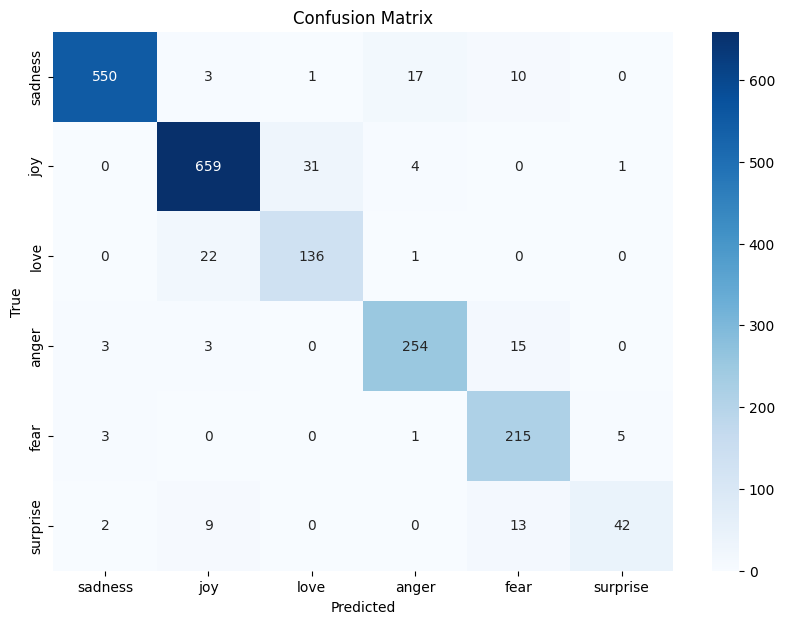

In [53]:
# Classification Report and Confusion Matrix
predictions = model.predict(test_tf_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)
true_labels = np.concatenate([y.numpy() for _, y in test_tf_dataset], axis=0)
print(classification_report(true_labels, predicted_labels, target_names=dataset["train"].features["label"].names))
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset["train"].features["label"].names, yticklabels=dataset["train"].features["label"].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


Let's test our model with custom sample inputs

In [41]:
# Testing with new sample input
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    predicted_class = int(predicted_class)
    return dataset["train"].features["label"].int2str(predicted_class)

In [47]:
# Example usage
sample_text = ["I am so happy today!", 
               "I feel very sad and lonely.", 
               "This is a neutral statement.", 
               "I am very confused about this situation.",
               "I feel angry about the recent events.",
               "I feel down today",
               ]
for text in sample_text:
    emotion = predict_emotion(text)
    print(f"Text: {text} | Predicted Emotion: {emotion}") 

Text: I am so happy today! | Predicted Emotion: joy
Text: I feel very sad and lonely. | Predicted Emotion: sadness
Text: This is a neutral statement. | Predicted Emotion: joy
Text: I am very confused about this situation. | Predicted Emotion: fear
Text: I feel angry about the recent events. | Predicted Emotion: anger
Text: I feel down today | Predicted Emotion: sadness
